In [31]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [32]:
import pandas as pd
import subprocess
import matplotlib.pyplot as plt
from itertools import combinations
from networkx import write_gpickle as write_g
import networkx as nx
import operator

In [33]:
plays_df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Shakespeare Network Analyses/Shakespeare_data.csv")
# Drop stage directions (where there isn't an act/scene/line)
plays_df = plays_df[pd.notna(plays_df['ActSceneLine'])]
plays_df[['Act','Scene','Line']] = plays_df['ActSceneLine'].str.split('.',expand = True).astype(float)
plays_df = plays_df.drop('ActSceneLine',axis=1)
# Drop Shakespeare's histories
tragedies = ["Hamlet","macbeth", "Othello","Merchant of Venice"]
plays_df = plays_df[plays_df["Play"].isin(tragedies)]
print("{} rows and {} columns".format(*plays_df.shape))
plays_df.head()

12638 rows and 8 columns


,Dataline,Play,PlayerLinenumber,Player,PlayerLine,Act,Scene,Line
32435,32436,Hamlet,1.0,BERNARDO,Who's there?,1.0,1.0,1.0
32436,32437,Hamlet,2.0,FRANCISCO,"Nay, answer me: stand, and unfold yourself.",1.0,1.0,2.0
32437,32438,Hamlet,3.0,BERNARDO,Long live the king!,1.0,1.0,3.0
32438,32439,Hamlet,4.0,FRANCISCO,Bernardo?,1.0,1.0,4.0
32439,32440,Hamlet,5.0,BERNARDO,He.,1.0,1.0,5.0


In [34]:
play_name = "Merchant of Venice"
single_play = plays_df[(plays_df['Play'] == play_name)]
# Group the df by character to get how often each speak
characters = single_play.groupby(['Player']).size().reset_index()
characters.rename(columns = {0: 'Count'}, inplace = True)
# Get top 20 characters
characters = characters[characters["Count"] > 5]

In [35]:
characters = characters["Player"].drop(labels=[13])

In [36]:
characters

1       ANTONIO
2       ARRAGON
4      BASSANIO
5         Clerk
6          DUKE
7         GOBBO
8      GRATIANO
9       JESSICA
10    LAUNCELOT
12      LORENZO
14      NERISSA
15       PORTIA
16      SALANIO
17     SALARINO
18      SALERIO
19      SHYLOCK
20     STEPHANO
21      Servant
22        TUBAL
Name: Player, dtype: object

In [37]:
def graphify(characters):
  play_graph = nx.Graph()
  play_graph.add_nodes_from(characters)
  scenes_df = single_play.groupby(['Act','Scene','Player']).size()
  scenes_df = scenes_df.loc[:,:,characters]
  for (act,scene), counts in scenes_df.groupby(['Act','Scene']):
    chars = counts.index.get_level_values(2).tolist()
    pairs = list(combinations(chars,2))
    for (a_char, b_char) in pairs:
        if play_graph.has_edge(a_char, b_char):
            play_graph[a_char][b_char]['weight'] += 1
        else:
            play_graph.add_edge(a_char, b_char,weight=1)
  return play_graph

In [38]:
wChars = graphify(characters)
woChars = graphify(characters.drop(labels=[1,4,8,15,14,19]))

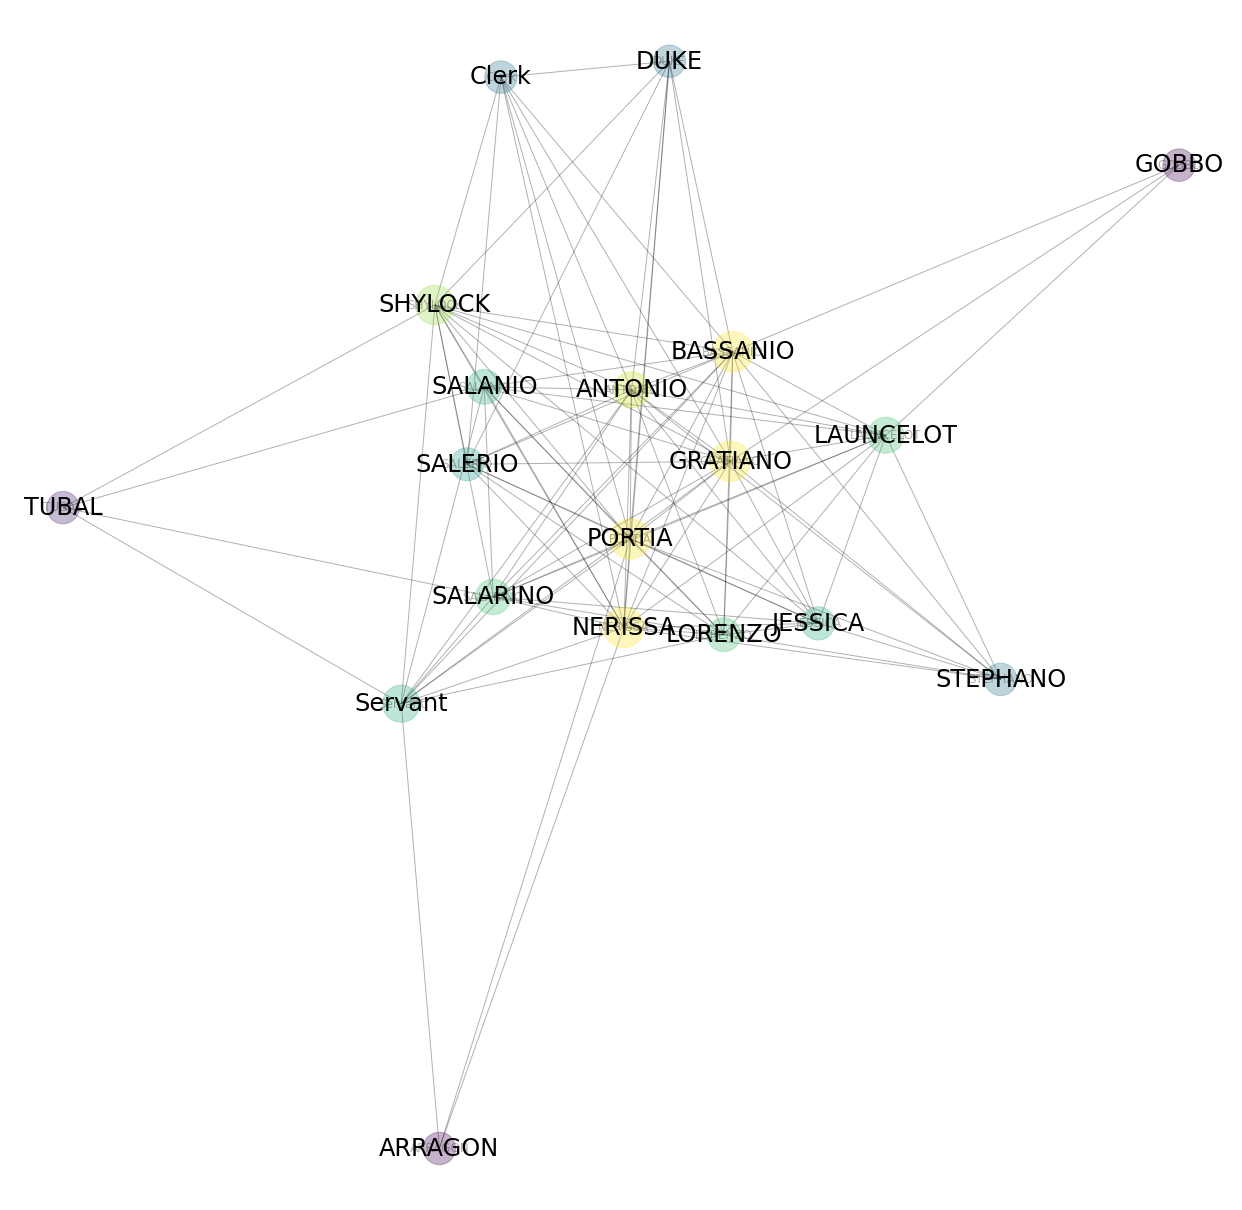

In [39]:
pos = nx.spring_layout(wChars)
betCent = nx.betweenness_centrality(wChars, normalized=True, endpoints=True)
node_color = [40000.0 * wChars.degree(v) for v in wChars]
node_size =  [v * 10000 for v in betCent.values()]
plt.figure(figsize=(22,22))
nx.draw_networkx(wChars, pos=pos, with_labels=True,
                 node_color=node_color,alpha=0.3,
                 node_size=node_size,seed=50)
nx.draw_networkx_labels(wChars, pos, font_size=24, font_family='sans-serif')
plt.axis('off');

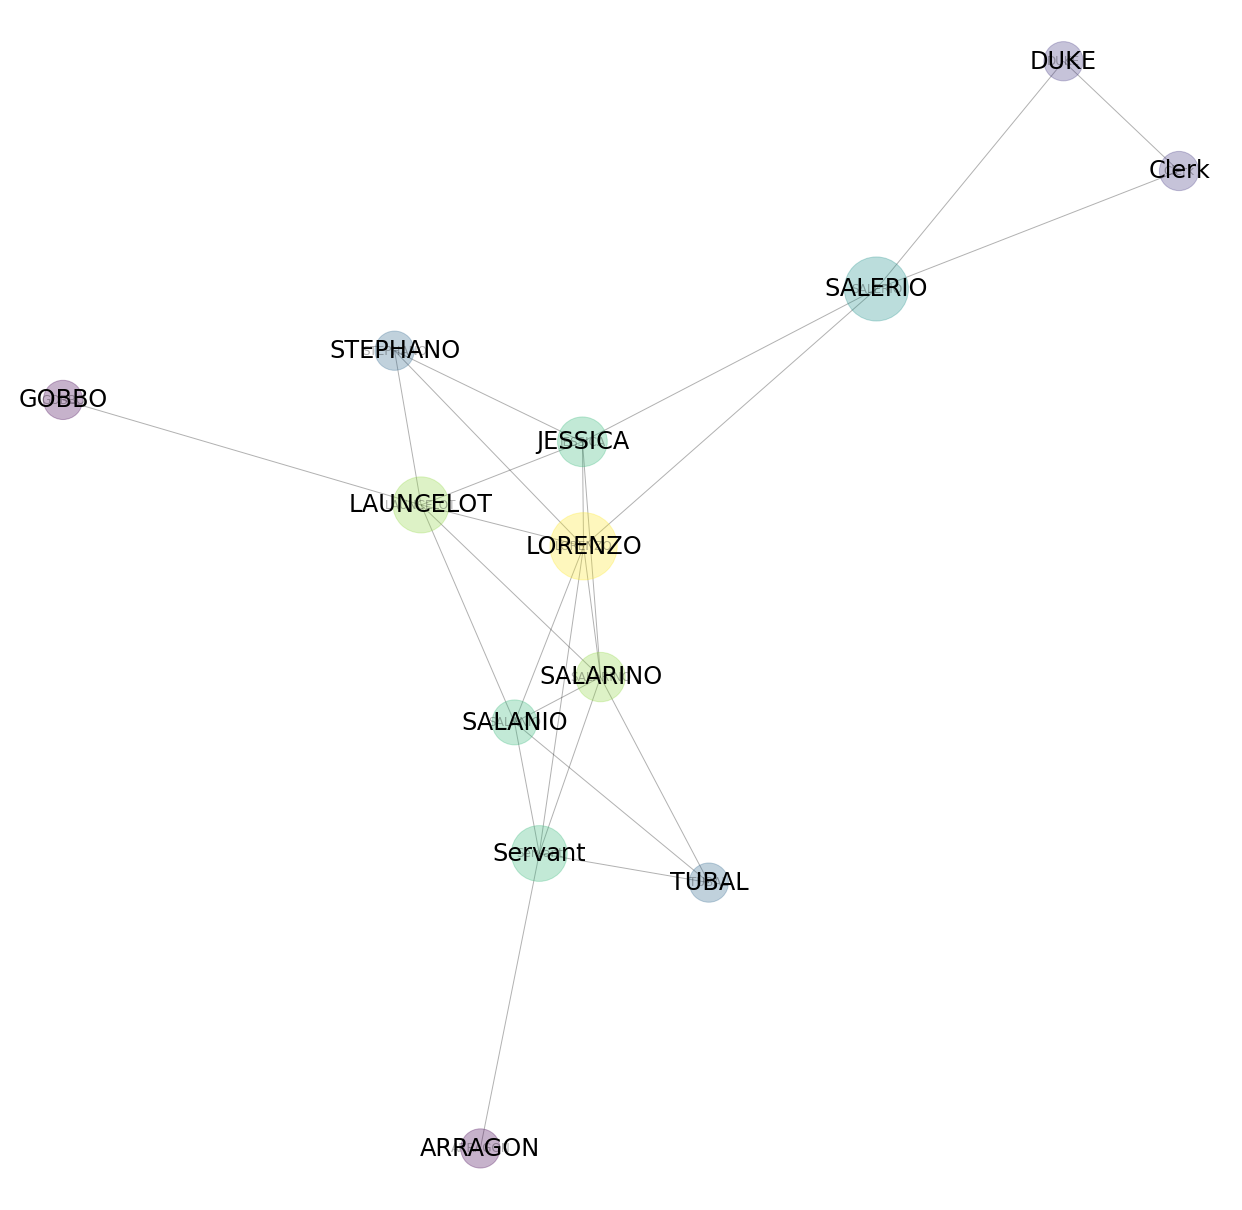

In [40]:
pos = nx.spring_layout(woChars)
betCent = nx.betweenness_centrality(woChars, normalized=True, endpoints=True)
node_color = [40000.0 * woChars.degree(v) for v in woChars]
node_size =  [v * 10000 for v in betCent.values()]
plt.figure(figsize=(22,22))
nx.draw_networkx(woChars, pos=pos, with_labels=True,
                 node_color=node_color,alpha=0.3,
                 node_size=node_size,seed=50)
nx.draw_networkx_labels(woChars, pos, font_size=24, font_family='sans-serif')
plt.axis('off');